# Exploratory Data Analysis

# 1) Import

In [2]:
import pandas as pd
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from optbinning import OptimalBinning

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(CVXPY) Feb 07 11:32:19 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 07 11:32:19 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
# 'src' folder path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../src'))

# verify the path
print("Caminho para a pasta 'src':", project_root)

# add to the sys.path
sys.path.append(project_root)

Caminho para a pasta 'src': c:\Users\lucas\OneDrive\Área de Trabalho\Data Science Projects\credit_scoring_project\src


# 2) Dataset Infos

Dataset info¶
ID: Unique identifier for each entry in the dataset.

Customer_ID: Identifier for each customer.

Month: Month of data collection.

Name: Name of the customer.

Age: Age of the customer.

SSN: Social Security Number of the customer.

Occupation: Occupation of the customer.

Annual_Income: Annual income of the customer.

Monthly_Inhand_Salary: Monthly salary after deductions.

Num_Bank_Accounts: Number of bank accounts the customer has.

Num_Credit_Card: Number of credit cards the customer has.

Interest_Rate: Interest rate applied on loans.

Num_of_Loan: Number of loans the customer has.

Type_of_Loan: Type of loan taken by the customer.

Delay_from_due_date: Number of days delayed from due date for payments.

Num_of_Delayed_Payment: Number of delayed payments made by the customer.

Changed_Credit_Limit: Indicates if the credit limit has been changed.

Num_Credit_Inquiries: Number of credit inquiries made by the customer.

Credit_Mix: Mix of different types of credit accounts held by the customer.

Outstanding_Debt: Amount of outstanding debt.

Credit_Utilization_Ratio: Ratio of credit used to credit available.

Credit_History_Year: Years of credit history.

Payment_of_Min_Amount: Indicates if minimum payment amount is met.

Total_EMI_per_month: Total Equated Monthly Installment (EMI) paid by the customer.

Amount_invested_monthly: Amount invested monthly by the customer.

Payment_Behaviour: Payment behavior of the customer.

Monthly_Balance: Monthly balance in the account.

target: Target variable - credit score of the customer.

In [4]:
df = pd.read_csv('../data/df_transformed.csv')
df.head()

,Unnamed: 0,id,customer_id,month,name,age,ssn,occupation,annual_income,monthly_inhand_salary,...,credit_mix,outstanding_debt,credit_utilization_ratio,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,target,credit_history_year
0,0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,...,_,809.980,26.823,No,49.575,80.415,High_spent_Small_value_payments,312.494,0,22
1,1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,NaN,...,Good,809.980,31.945,No,49.575,118.280,Low_spent_Large_value_payments,284.629,0,-1
2,2,0x1604,CUS_0xd40,March,Aaron Maashoh,-1,821-00-0265,Scientist,19114.120,NaN,...,Good,809.980,28.609,No,49.575,81.700,Low_spent_Medium_value_payments,331.210,0,22
3,3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,NaN,...,Good,809.980,31.378,No,49.575,199.458,Low_spent_Small_value_payments,223.451,0,22
4,4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.120,1824.843,...,Good,809.980,24.797,No,49.575,41.420,High_spent_Medium_value_payments,341.489,0,22


# 3) Analysis

## 3.0) Bad Rate per month

In [7]:
target_per_month = df.groupby(['month','target']).size().unstack(fill_value=0)
target_per_month['total_frequency'] = target_per_month[0]+target_per_month[1]
target_per_month['pct_bad_rate'] = (target_per_month[1]/target_per_month['total_frequency'])*100
target_per_month


target,0,1,total_frequency,pct_bad_rate
month,,,,
April,2357,3670,6027,60.892650
August,2413,3602,6015,59.883624
February,2016,3539,5555,63.708371
January,1975,3582,5557,64.459241
July,2411,3614,6025,59.983402
June,2362,3728,6090,61.215107
March,1984,3551,5535,64.155375
May,2310,3712,6022,61.640651


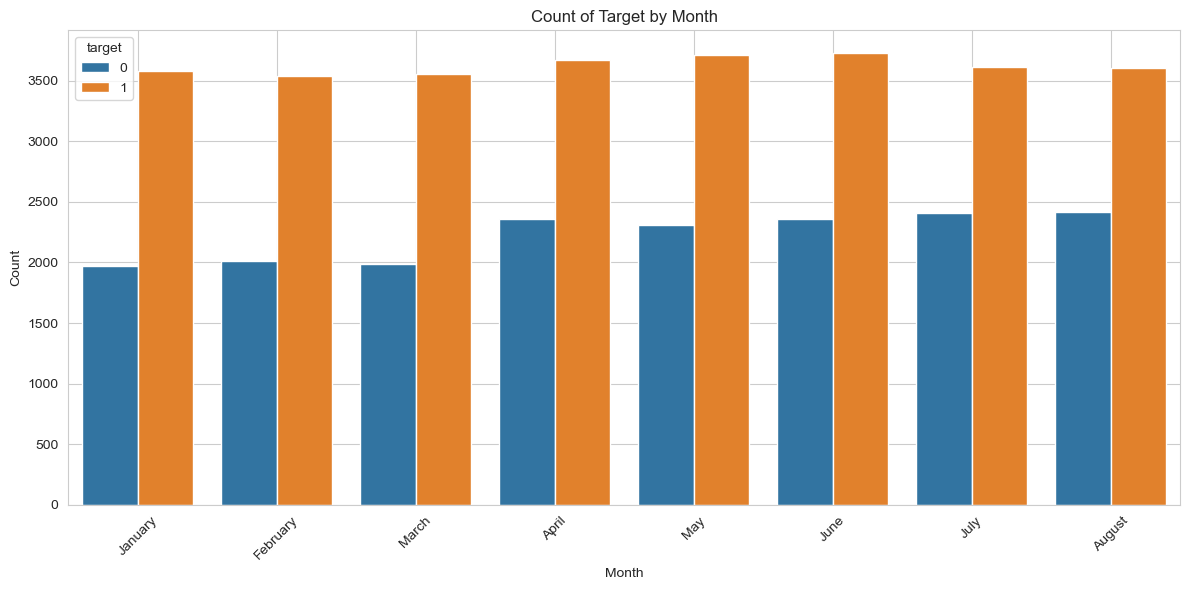

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(x='month', hue='target', data=df)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Target by Month')
plt.xticks(rotation=45)
plt.legend(title='target')
plt.grid(True)
plt.tight_layout()
plt.show()

- From January until August the frequency and the bad rate are stable. So I will keep all the months in the database

## 3.1) Age by target

In [16]:
df_age_bins = df.copy()

bins = [-1,18,25,34,45,60]
labels = ['0-18','18-25','25-34','34-45','45+']
df_age_bins['age_bins'] = pd.cut(df_age_bins['age'], bins=bins, labels = labels)
df_age_bins['age_bins'].value_counts()

age_bins
34-45    14320
25-34    11921
18-25     9056
45+       6315
0-18      1119
Name: count, dtype: int64

In [18]:
age_per_month = df_age_bins.groupby(['age_bins','target']).size().unstack(fill_value=0)
age_per_month['total_frequency'] = age_per_month[0]+age_per_month[1]
age_per_month['pct_bad_rate'] = (age_per_month[1]/age_per_month['total_frequency'])*100
age_per_month

C:\Users\lucas\AppData\Local\Temp\ipykernel_12772\4146296429.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_per_month = df_age_bins.groupby(['age_bins','target']).size().unstack(fill_value=0)


target,0,1,total_frequency,pct_bad_rate
age_bins,,,,
0-18,343,776,1119,69.347632
18-25,3175,5881,9056,64.940371
25-34,4005,7916,11921,66.403825
34-45,5002,9318,14320,65.069832
45+,4566,1749,6315,27.695962


c:\ProgramData\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\ProgramData\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


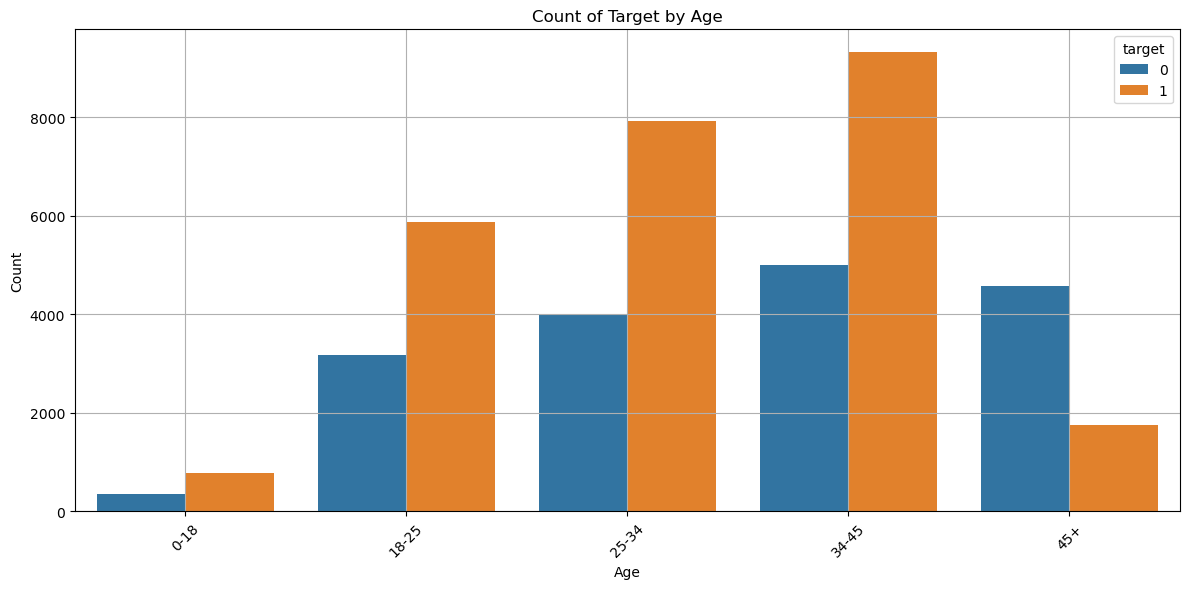

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(x='age_bins', hue='target', data=df_age_bins)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of Target by Age')
plt.xticks(rotation=45)
plt.legend(title='target')
plt.grid(True)
plt.tight_layout()
plt.show()

- The `34-45` bin have the most frequency of clients by 33.5%, followed by the `25-34` bin with 27.9%. 

- In terms of bad rate, the `45+` bin has the lowest bad rate 27.7%, being the best clients. The worst are the `0-18` bin by 69% of bad rate.


## 3.2) Credit Mix by target

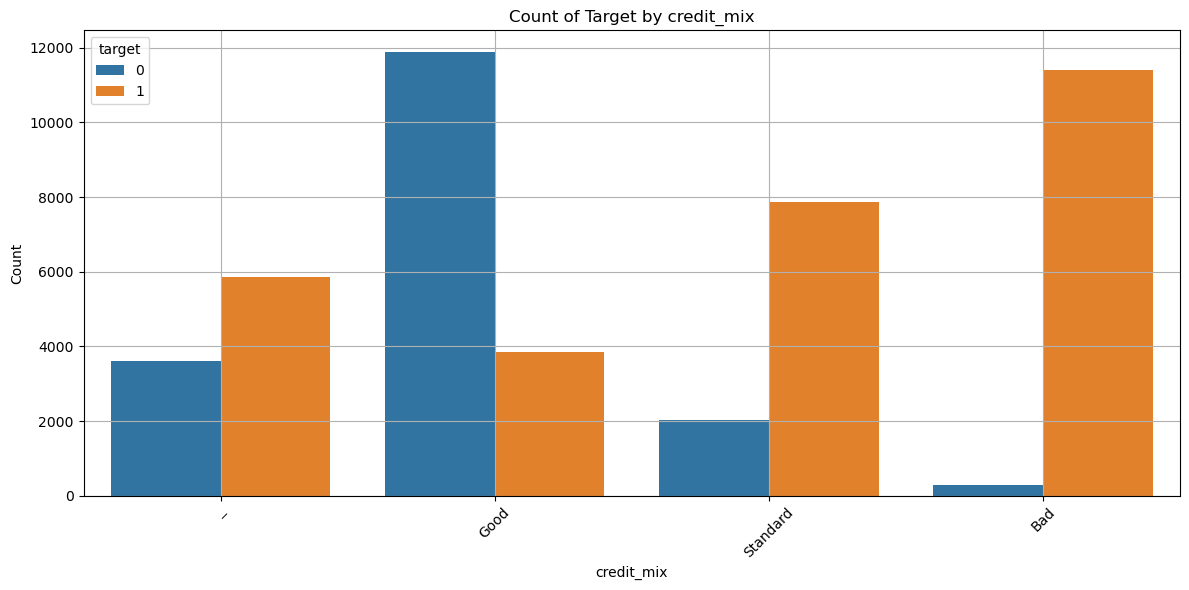

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(x='credit_mix', hue='target', data=df)
plt.xlabel('credit_mix')
plt.ylabel('Count')
plt.title('Count of Target by credit_mix')
plt.xticks(rotation=45)
plt.legend(title='target')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
df_cm_bins = df.copy()

cm_per_month = df_cm_bins.groupby(['credit_mix','target']).size().unstack(fill_value=0)
cm_per_month['total_frequency'] = cm_per_month[0]+cm_per_month[1]
cm_per_month['pct_bad_rate'] = (cm_per_month[1]/cm_per_month['total_frequency'])*100
cm_per_month

target,0,1,total_frequency,pct_bad_rate
credit_mix,,,,
Bad,288,11409,11697,97.538
Good,11875,3861,15736,24.536
Standard,2043,7859,9902,79.368
_,3622,5869,9491,61.838


- Obviously the `Bad` ones are the worst kind of clients. The bad_rate is 97%, and the best ones if the `Good` ones with 24%. 
- This feature can be a strong one to predict values.

## 3.3) Anual Income

In [45]:
x = df['annual_income']
y = df['target']

optbin = OptimalBinning(
    dtype = 'numerical',
    solver = 'cp',
    max_n_prebins = 5,
    min_bin_size = 0.05,
    min_event_rate_diff = 0.015
)

optbin.fit(x,y)

binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 20994.00)",15040,0.321189,2785,12255,0.814827,-0.99523,0.265130,0.031838
1,"[20994.00, 83710.82)",23298,0.497544,9125,14173,0.608335,0.046136,0.001065,0.000133
2,"[83710.82, inf)",8488,0.181267,5918,2570,0.302780,1.320549,0.321320,0.037479
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,46826,1.000000,17828,28998,0.619271,,0.587514,0.069450


In [46]:
optbin.splits

array([20993.99804688, 83710.8203125 ])

In [47]:
bins = [-1000000,20993.99804688, 83710.8203125,10000000 ]
labels = ['0-21k','21k-83k','83k+']
df_age_bins['income_bins'] = pd.cut(df_age_bins['annual_income'], bins=bins, labels = labels)
df_age_bins['income_bins'].value_counts()

income_bins
21k-83k    23298
0-21k      15040
83k+        8211
Name: count, dtype: int64

c:\ProgramData\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\ProgramData\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


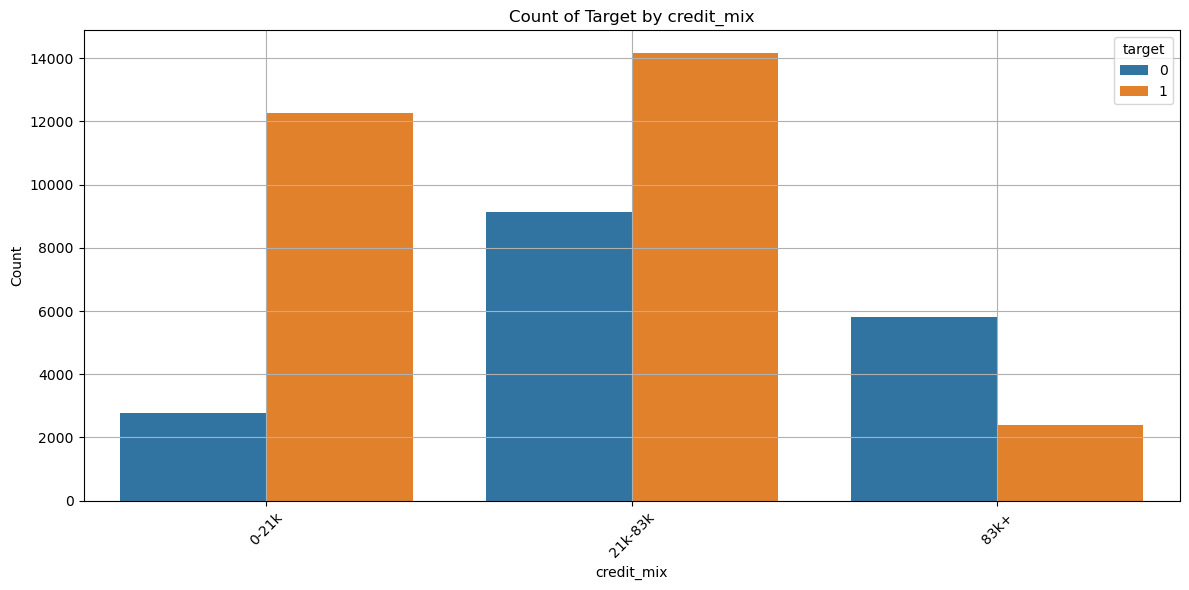

In [48]:
plt.figure(figsize=(12, 6))
sns.countplot(x='income_bins', hue='target', data=df_age_bins)
plt.xlabel('credit_mix')
plt.ylabel('Count')
plt.title('Count of Target by credit_mix')
plt.xticks(rotation=45)
plt.legend(title='target')
plt.grid(True)
plt.tight_layout()
plt.show()

- Clearly the `83+` bin has the best clients with 30% of bad rate, and the bin `0-21k` has the worst clients with 81% of bad rate

### Income by age

In [49]:
income_age = df_age_bins.groupby(['age_bins','income_bins']).size().unstack(fill_value=0)
income_age

C:\Users\lucas\AppData\Local\Temp\ipykernel_12772\2477289107.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_age = df_age_bins.groupby(['age_bins','income_bins']).size().unstack(fill_value=0)


income_bins,0-21k,21k-83k,83k+
age_bins,,,
0-18,367,591,152
18-25,3035,4398,1573
25-34,3935,6035,1882
34-45,5027,6996,2217
45+,925,3280,2067


In [50]:
total_count = df_age_bins.groupby(['age_bins', 'income_bins']).size()
target_count = df_age_bins.groupby(['age_bins', 'income_bins'])['target'].sum()
percent_target = (target_count / total_count * 100).unstack(fill_value=0)
percent_target

C:\Users\lucas\AppData\Local\Temp\ipykernel_12772\924008686.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_count = df_age_bins.groupby(['age_bins', 'income_bins']).size()
C:\Users\lucas\AppData\Local\Temp\ipykernel_12772\924008686.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_count = df_age_bins.groupby(['age_bins', 'income_bins'])['target'].sum()


income_bins,0-21k,21k-83k,83k+
age_bins,,,
0-18,85.013624,69.881557,30.921053
18-25,84.481054,63.096862,32.167832
25-34,85.463787,64.623032,32.412327
34-45,82.076785,63.979417,29.905277
45+,31.027027,29.329268,23.657475


- It's clear that highest the income, lowest the bad rate in all age bins.
- The best age group is `45+` and the worst if `0-18`
- These 2 features follow a pattern

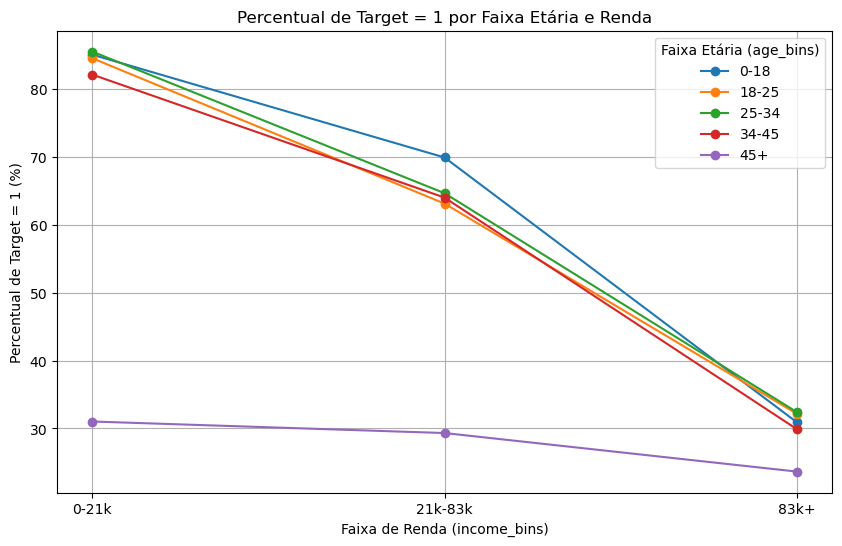

In [51]:
# Plotando cada faixa etária como uma linha
plt.figure(figsize=(10, 6))
for age_bin in percent_target.index:
    plt.plot(percent_target.columns, percent_target.loc[age_bin], marker='o', label=age_bin)

# Personalização do gráfico
plt.xlabel("Faixa de Renda (income_bins)")
plt.ylabel("Percentual de Target = 1 (%)")
plt.title("Percentual de Target = 1 por Faixa Etária e Renda")
plt.legend(title="Faixa Etária (age_bins)")
plt.grid(True)

# Exibir o gráfico
plt.show()

### Income by credit mix

In [52]:
income_mix = df_age_bins.groupby(['credit_mix','income_bins']).size().unstack(fill_value=0)
income_mix

C:\Users\lucas\AppData\Local\Temp\ipykernel_12772\1853978156.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_mix = df_age_bins.groupby(['credit_mix','income_bins']).size().unstack(fill_value=0)


income_bins,0-21k,21k-83k,83k+
credit_mix,,,
Bad,5849,5700,66
Good,2146,8051,5439
Standard,3968,4839,1057
_,3077,4708,1649


In [53]:
total_count = df_age_bins.groupby(['credit_mix', 'income_bins']).size()
target_count = df_age_bins.groupby(['credit_mix', 'income_bins'])['target'].sum()
percent_target = (target_count / total_count * 100).unstack(fill_value=0)
percent_target

C:\Users\lucas\AppData\Local\Temp\ipykernel_12772\3795804420.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_count = df_age_bins.groupby(['credit_mix', 'income_bins']).size()
C:\Users\lucas\AppData\Local\Temp\ipykernel_12772\3795804420.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_count = df_age_bins.groupby(['credit_mix', 'income_bins'])['target'].sum()


income_bins,0-21k,21k-83k,83k+
credit_mix,,,
Bad,97.332877,97.771930,98.484848
Good,23.811743,23.686499,26.089355
Standard,89.616935,79.086588,42.194891
_,81.085473,60.875106,28.562765


- The `Bad` mix group doesn't change with the income
- The `Standard` and the `No Info` group are the ones who changes with the highest incomes 

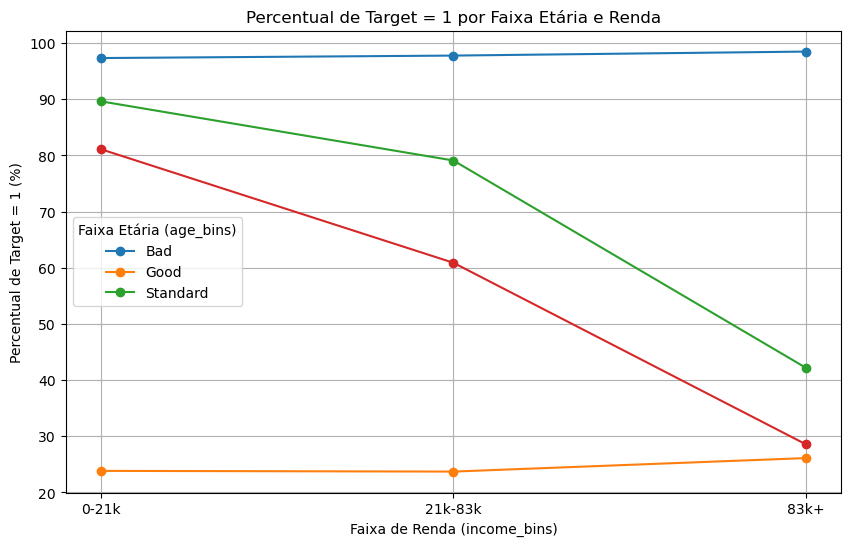

In [54]:
# Plotando cada faixa etária como uma linha
plt.figure(figsize=(10, 6))
for age_bin in percent_target.index:
    plt.plot(percent_target.columns, percent_target.loc[age_bin], marker='o', label=age_bin)

# Personalização do gráfico
plt.xlabel("Faixa de Renda (income_bins)")
plt.ylabel("Percentual de Target = 1 (%)")
plt.title("Percentual de Target = 1 por Faixa Etária e Renda")
plt.legend(title="Faixa Etária (age_bins)")
plt.grid(True)

# Exibir o gráfico
plt.show()

## 3.4) Num of Accounts, credit cards and loans

In [17]:
x = df['num_bank_accounts']
y = df['target']

optbin = OptimalBinning(
    dtype = 'numerical',
    solver = 'cp',
    max_n_prebins = 5,
    min_bin_size = 0.05,
    min_event_rate_diff = 0.015
)

optbin.fit(x,y)

binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",8228,0.176,6120,2108,0.256,1.552,0.420,0.048
1,"[2.50, 5.50)",14537,0.310,8782,5755,0.396,0.909,0.267,0.032
2,"[5.50, 8.50)",16654,0.356,2561,14093,0.846,-1.219,0.417,0.049
3,"[8.50, 9.50)",3494,0.075,63,3431,0.982,-3.511,0.403,0.034
4,"[9.50, inf)",3913,0.084,302,3611,0.923,-1.995,0.215,0.023
5,Special,0,0.000,0,0,0.000,0.000,0.000,0.000
6,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000
Totals,,46826,1.000,17828,28998,0.619,,1.722,0.187


- We can see a particular behavior. Highest the number of banks that the client have, highest the bad rate. 
- If the client have an account in a lot of different banks, it's easier to not pay an invoice, loan and any other credit product... 

In [18]:
x = df['num_credit_card']
y = df['target']

optbin = OptimalBinning(
    dtype = 'numerical',
    solver = 'cp',
    max_n_prebins = 5,
    min_bin_size = 0.05,
    min_event_rate_diff = 0.015
)

optbin.fit(x,y)

binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",3343,0.071,3327,16,0.005,5.824,1.084,0.063
1,"[2.50, 4.50)",10414,0.222,6584,3830,0.368,1.028,0.244,0.029
2,"[4.50, 5.50)",8717,0.186,3500,5217,0.598,0.087,0.001,0.000
3,"[5.50, 7.50)",14007,0.299,3817,10190,0.727,-0.495,0.068,0.008
4,"[7.50, inf)",10345,0.221,600,9745,0.942,-2.301,0.696,0.072
5,Special,0,0.000,0,0,0.000,0.000,0.000,0.000
6,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000
Totals,,46826,1.000,17828,28998,0.619,,2.093,0.173


- The same behavior with number of credit cards. More credit cards, worst is the client
- Usually some clients have a lot of CC to pay invoice of other CC and the debt just grow...

In [20]:
x = df['num_of_loan']
y = df['target']

optbin = OptimalBinning(
    dtype = 'numerical',
    solver = 'cp',
    max_n_prebins =3,
    min_bin_size = 0.05,
    min_event_rate_diff = 0.015
)

optbin.fit(x,y)

binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",10632,0.227,7052,3580,0.337,1.164,0.317,0.038
1,"[1.50, 4.50)",20059,0.428,10013,10046,0.501,0.483,0.104,0.013
2,"[4.50, inf)",16135,0.345,763,15372,0.953,-2.517,1.226,0.122
3,Special,0,0.000,0,0,0.000,0.000,0.000,0.000
4,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000
Totals,,46826,1.000,17828,28998,0.619,,1.647,0.173


- The same behavior again with the number of loans
- More loans token, the worst is the client because it became difficult to pay a lot of loans

## 3.5) Delay and other infos

In [22]:
x = df['num_of_delayed_payment']
y = df['target']

optbin = OptimalBinning(
    dtype = 'numerical',
    solver = 'cp',
    max_n_prebins =5,
    min_bin_size = 0.05,
    min_event_rate_diff = 0.015
)

optbin.fit(x,y)

binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -0.50)",3654,0.078,1564,2090,0.572,0.197,0.003,0.000
1,"[-0.50, 7.50)",9448,0.202,6956,2492,0.264,1.513,0.460,0.053
2,"[7.50, 12.50)",10583,0.226,5564,5019,0.474,0.590,0.082,0.010
3,"[12.50, 14.50)",2877,0.061,1002,1875,0.652,-0.140,0.001,0.000
4,"[14.50, inf)",20264,0.433,2742,17522,0.865,-1.368,0.616,0.072
5,Special,0,0.000,0,0,0.000,0.000,0.000,0.000
6,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000
Totals,,46826,1.000,17828,28998,0.619,,1.163,0.135


- This feature doesn't follow a pattern. But if we ignore the [-inf,0.5] bin, its clear to see that the increse of number of delayed payment increases the bad rate